# Final Project

## Import Data
Using pandas, we can import the dataset into df_credit

In [8]:
import pandas as pd

df_credit = pd.read_csv("../data/creditcard.csv")

To ensure randomness, the data will be shuffled

In [ ]:
df_credit = df_credit.sample(frac=1)

## Data Analysis

First, we need to know if there are any missing values to address. From glancing at the raw data, there doesn't seem to be any missing data or values that represent missing values.

In [11]:
print('Number of missing (null) values in the dataframe: ', df_credit.isnull().sum().sum())

Number of missing (null) values in the dataframe:  0


Because there are no missing values, we will continue analyzing the data by checking if the data is encoded properly. We do this by checking the features data type.

In [12]:
print(df_credit.dtypes)

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object


The data is encoded properly, so no changes will be made. We can now proceed to further analyze the data by observing the distribution of classes.

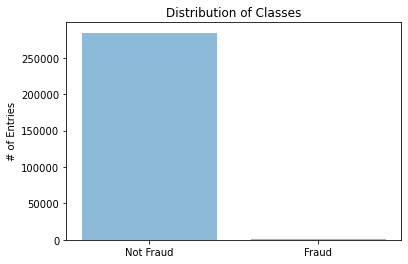

amount of class 0 (no fraud):  284315
amount of class 1 (fraud):  492
0.173 % of the data are fraudulent credit charges


In [15]:
import numpy as np
import matplotlib.pyplot as plt

classes = ('Not Fraud', 'Fraud')
y_pos = np.arange(len(classes))
performance = [num_of_nofraud, num_of_fraud]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, classes)
plt.ylabel('# of Entries')
plt.title('Distribution of Classes')

plt.show()

num_of_nofraud = df_credit['Class'].value_counts()[0]
num_of_fraud = df_credit['Class'].value_counts()[1]
print('amount of class 0 (no fraud): ', num_of_nofraud)
print('amount of class 1 (fraud): ', num_of_fraud)

print(round(num_of_fraud/len(df_credit) * 100, 3), '% of the data are fraudulent credit charges')

The data has a clear imbalance and will hurt our model with high variance. This leads to a model that overfits the data.

Next, we can display statistical data on the only two features that have not been already transformed and provide us with a descriptive title: "Time" and "Amount". 

In [16]:
fraud = df_credit[df_credit['Class'] == 1]
nonfraud = df_credit[df_credit['Class'] == 0]

## How the amount spent relates to fraudulent charges
print(pd.concat([fraud.Amount.describe(), nonfraud.Amount.describe()], axis=1))

## How the time frame between purchases relates to fraudulent charges
print(pd.concat([fraud.Time.describe(), nonfraud.Time.describe()], axis=1))

            Amount         Amount
count   492.000000  284315.000000
mean    122.211321      88.291022
std     256.683288     250.105092
min       0.000000       0.000000
25%       1.000000       5.650000
50%       9.250000      22.000000
75%     105.890000      77.050000
max    2125.870000   25691.160000
                Time           Time
count     492.000000  284315.000000
mean    80746.806911   94838.202258
std     47835.365138   47484.015786
min       406.000000       0.000000
25%     41241.500000   54230.000000
50%     75568.500000   84711.000000
75%    128483.000000  139333.000000
max    170348.000000  172792.000000


These values do give us some insight as to how fraudulent charges can be identified from these two features alone, but is clearly not going to work on their own.

Another interesting characteristic of these feature columns is that they are the only columns to not have gone through PCA transformation. This can be seen by their distribution of data.

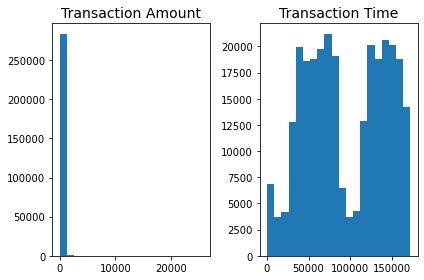

In [19]:
## lets see what amount and time look like
amount_val = df_credit['Amount'].values
time_val = df_credit['Time'].values
n_bins = 20

fig, axs = plt.subplots(1, 2, tight_layout=True)

# a histogram will be used to see the general distribution
# of values through a histogram.
axs[0].set_title('Transaction Amount', fontsize=14)
axs[0].hist(amount_val, bins=n_bins)

axs[1].set_title('Transaction Time', fontsize=14)
axs[1].hist(time_val, bins=n_bins)

plt.show()

The plotted distribution of the data shows us just how skewed the data is. There are outliers that could hurt the classification ability of our model. There is also an extremely large range in values as compared to the other features, as seen below.

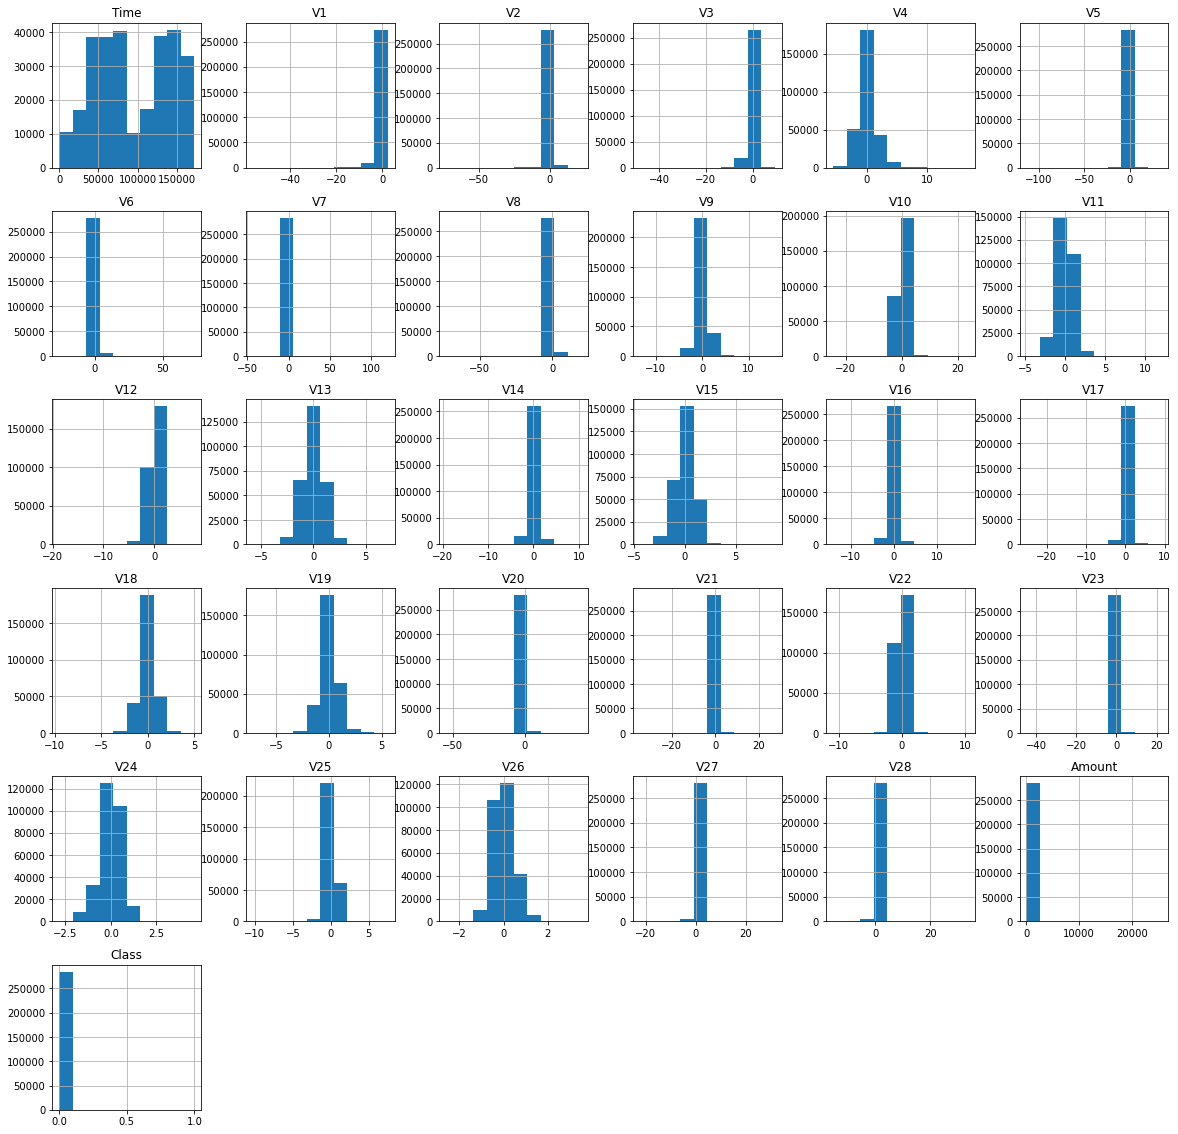

In [23]:
df_credit.hist(figsize=(20, 20));

## Data Preprocessing

To fix the class imbalance present in our dataframe, we decided to split our data so that the class distribution is exactly 50/50.

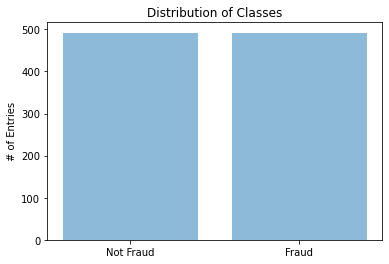

amount of class 0 (no fraud):  492
amount of class 1 (fraud):  492


In [28]:
df_fraud = df_credit.loc[df_credit['Class'] == 1]

# We know that there are 492 fraud entries, so we should limit the
# number of non fraudulent entries to 492 to keep it even.
df_nonfraud = df_credit.loc[df_credit['Class'] == 0][:len(df_fraud.index)]

# we combine the data frames we created into one evenly
# distributed dataframe.
df_credit_new = pd.concat([df_fraud, df_nonfraud])

# Shuffle
df_credit_new = df_credit_new.sample(frac=1)

# Illustrate the new class count
classes = ('Not Fraud', 'Fraud')
y_pos = np.arange(len(classes))
performance = [num_of_nofraud, num_of_fraud]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, classes)
plt.ylabel('# of Entries')
plt.title('Distribution of Classes')

plt.show()

num_of_nofraud = df_credit_new['Class'].value_counts()[0]
num_of_fraud = df_credit_new['Class'].value_counts()[1]
print('amount of class 0 (no fraud): ', num_of_nofraud)
print('amount of class 1 (fraud): ', num_of_fraud)

Now, the class distribution is even and the size of the dataset is cut down which makes future functions a lot easier and faster to process.

The next step to making the data reliable is to perform some transformation on the "Time" and "Amount" feature columns. We decided to perform standard scaling.

Before StandardScaler fitting and transformation: 
             Time         V1        V2         V3         V4        V5  \
79883   0.337794  -1.322789  1.552768  -2.276921   2.992117 -1.947064   
11343  -0.393646 -14.179165  7.421370 -21.405836  11.927512 -7.974281   
235644  2.054318  -1.541678  3.846800  -7.604114   3.121459 -1.254924   
234574  2.045741  -1.053840  4.362801  -6.023534   5.304534  1.480738   
125342  0.706842  -7.139060  2.773082  -6.757845   4.446456 -5.464428   

              V6         V7        V8        V9  ...       V21       V22  \
79883  -0.480288  -1.362388  0.953242 -2.329629  ...  0.614969 -0.195200   
11343  -2.202710 -15.471612 -0.356595 -6.380125  ... -2.366836  1.130955   
235644 -2.084875  -2.385027  1.471140 -2.530507  ...  1.096405  1.064222   
234574 -2.193821  -1.530817  0.626857 -4.037021  ...  0.397954 -0.945402   
125342 -1.713401  -6.485365  3.409395 -3.053493  ...  1.303250 -0.016118   

             V23       V24       V25       V26      

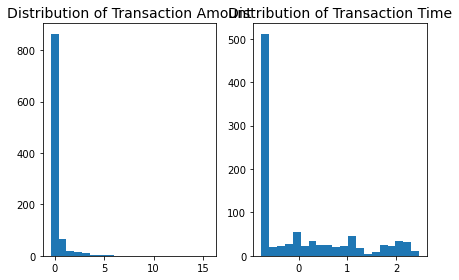

In [33]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

## Before the standard scaler fitting and transformation
print("Before StandardScaler fitting and transformation: \n", df_credit_new.head())

## Time and Amount will be transformed with StandardScaler
df_credit_new = df_credit_new.assign(Time=sc.fit_transform(df_credit_new['Time'].values.reshape(-1, 1)),
                             Amount=sc.fit_transform(df_credit_new['Amount'].values.reshape(-1, 1)))

## See what the new transformed columns look like
print("After StandardScaler fitting and transformation: \n", df_credit_new.head())

# Create a histogram with these new values
amount_val = df_credit_new['Amount'].values
time_val = df_credit_new['Time'].values

n_bins = 20

fig, axs = plt.subplots(1, 2, tight_layout=True)

axs[0].set_title('Transaction Amount', fontsize=14)
axs[0].hist(amount_val, bins=n_bins)

axs[1].set_title('Transaction Time', fontsize=14)
axs[1].hist(time_val, bins=n_bins)

plt.show()

The last thing to do before moving on to Feature Selection is to seperate the data between training and testing data.

In [36]:
from sklearn.model_selection import train_test_split

X, y = df_credit_new.iloc[:, :-1].values, df_credit_new.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2, random_state = 1, stratify = y)

## Feature Selection

Our team decided to use sequential backwards selection, SBS, to identify feature importance.

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from itertools import combinations
from sklearn.metrics import accuracy_score

class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.2, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

We will be performing SBS on three different models: Logistic Regression, Support Vector Machine, and Random Forest.

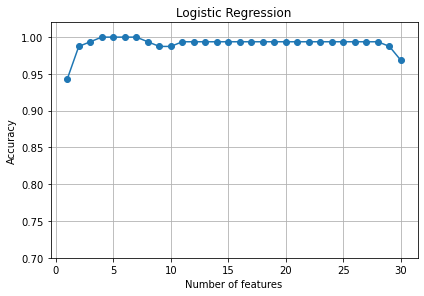

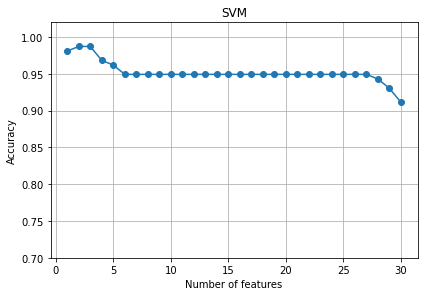

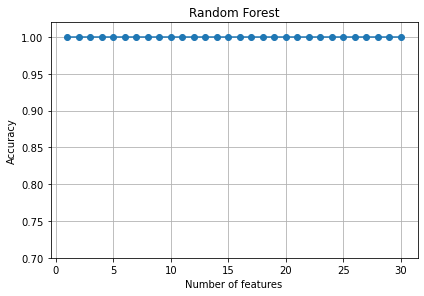

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

## Declare the learning algorithms that will be used
lreg = LogisticRegression(max_iter=10000)
svm = SVC()
rf = RandomForestClassifier()

### selecting features
## Logistic Regression
sbs = SBS(lreg, k_features=1)
sbs.fit(X_train, y_train)

# plot
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
plt.title("Logistic Regression")
plt.show()

## SVM
sbs = SBS(svm, k_features=1)
sbs.fit(X_train, y_train)

# plot
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
plt.title("SVM")
plt.show()

## Random Forest
sbs = SBS(rf, k_features=1)
sbs.fit(X_train, y_train)

# plot
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
plt.title("Random Forest")
plt.show()


## Hyper-Parameter Tuning

In [39]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

# Setup pipes

pipe_lr = make_pipeline(StandardScaler(),
                         LogisticRegression(random_state=1, max_iter=10000))
pipe_svm = make_pipeline(StandardScaler(),
                         SVC(random_state=1))
pipe_rf = make_pipeline(StandardScaler(),
                        RandomForestClassifier())

# Grid search feature extraction

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

# Grid Search on lr
param_grid = [{'logisticregression__C': param_range, 
               'logisticregression__solver': ['lbfgs'],
               'logisticregression__penalty':['l2']},
              {'logisticregression__C': param_range,
               'logisticregression__solver': ['liblinear'],
               'logisticregression__penalty':['l1','l2']},
              {'logisticregression__C': param_range,
               'logisticregression__solver': ['sag'],
               'logisticregression__penalty':['l2']}]

gs = GridSearchCV(pipe_lr, 
                  param_grid,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
best_params_LR = gs.best_params_
print('Grid Search best score (LR): %f' % gs.best_score_)
print('Grid Search best params(LR): ', best_params_LR)

# Grid Search on svm
param_grid = [{'svc__C': param_range, 
               'svc__kernel': ['linear']},
              {'svc__C': param_range, 
               'svc__gamma': param_range, 
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(pipe_svm, 
                  param_grid, 
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
best_params_SVM =gs.best_params_
print('Grid Search best score (SVM): %f' % gs.best_score_)
print('Grid Search best params (SVM): ', best_params_SVM)

# Grid Search on rf
param_grid = [{'randomforestclassifier__n_estimators': [100, 120, 140, 160, 180, 200], 
               'randomforestclassifier__max_depth': [5, 10, 20, 30, None],
               'randomforestclassifier__class_weight': ['balanced', 'balanced_subsample', {0: 1, 1: 1}, {0: 1, 1: 5}]}]

gs = GridSearchCV(pipe_rf,
                  param_grid,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
best_params_RF = gs.best_params_
print('Grid Search best score (RF): %f' % gs.best_score_)
print('Grid Search best params (RF): ', best_params_RF)

Grid Search best score (LR): 0.996178
Grid Search best params(LR):  {'logisticregression__C': 1.0, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
Grid Search best score (SVM): 0.997452
Grid Search best params (SVM):  {'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
Grid Search best score (RF): 0.998726
Grid Search best params (RF):  {'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__max_depth': 5, 'randomforestclassifier__n_estimators': 100}
